In [1]:
!pip install squarify

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd '/content/gdrive/My Drive/LDS0_K287_Online_PhamMinhQuang/Project1/'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS0_K287_Online_PhamMinhQuang/Project1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime
import re

In [4]:
# đọc data
df = pd.read_csv('CDNOW_master.txt', header = None)
df[0] = df[0].apply(lambda x: re.sub("\s{2,}"," ", x.strip()))
df = df[0].str.split(' ', expand=True)
df.columns =['customer_id', 'date', 'quantity', 'gross_sales']

EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  69659 non-null  object
 1   date         69659 non-null  object
 2   quantity     69659 non-null  object
 3   gross_sales  69659 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


Preprocessing

In [6]:
# chỉnh lại kiểu dữ liệu các cột cho phù hợp
string_to_date = lambda x : datetime.strptime(x, "%Y%m%d").date()
df['date'] = df['date'].apply(string_to_date)
df['date'] = df['date'].astype('datetime64[ns]')
df['quantity'] = df['quantity'].astype('int')
df['gross_sales'] = df['gross_sales'].astype('float')
df['order_id'] = [i for i in range(1, len(df) + 1)]
df = df.dropna()

In [7]:
df.head(3)

,customer_id,date,quantity,gross_sales,order_id
0,00001,1997-01-01,1,11.77,1
1,00002,1997-01-12,1,12.00,2
2,00002,1997-01-12,5,77.00,3


In [8]:
df.tail(3)

,customer_id,date,quantity,gross_sales,order_id
69656,23569,1997-03-25,2,25.74,69657
69657,23570,1997-03-25,3,51.12,69658
69658,23570,1997-03-26,2,42.96,69659


In [9]:
print('Transactions timeframe from {} to {}'.format(df['date'].min(), df['date'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.customer_id.isnull()].shape[0]))
print('{:,} unique customer_id'.format(len(df.customer_id.unique())))

Transactions timeframe from 1997-01-01 00:00:00 to 1998-06-30 00:00:00
0 transactions don't have a customer id
23,570 unique customer_id


### Create RFM analysis for each customers

In [10]:
max_date = df['date'].max().date()
Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)
df_RFM = df.groupby('customer_id').agg({'date': Recency,
                                        'order_id': Frequency,
                                        'gross_sales': Monetary })

In [11]:
df_RFM.head()

,date,order_id,gross_sales
customer_id,,,
00001,545,1,11.77
00002,534,2,89.00
00003,33,6,156.46
00004,200,4,100.50
00005,178,11,385.61


In [12]:
df_RFM.columns=['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary',ascending = False)

In [13]:
df_RFM.head()

,Recency,Frequency,Monetary
customer_id,,,
07592,1,201,13990.93
14048,0,217,8976.33
07983,5,149,6973.07
19339,445,56,6552.70
07931,17,62,6497.18


In [14]:
df_RFM.shape

(23570, 3)

<ipython-input-15-6058f0b462c6>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_RFM['Recency'])# Plot distribution of R
<ipython-input-15-6058f0b462c6>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_RFM['Frequency'])# Plot distribution of F
<ipython-input-15-6058f0b462c6>:8: UserWarning

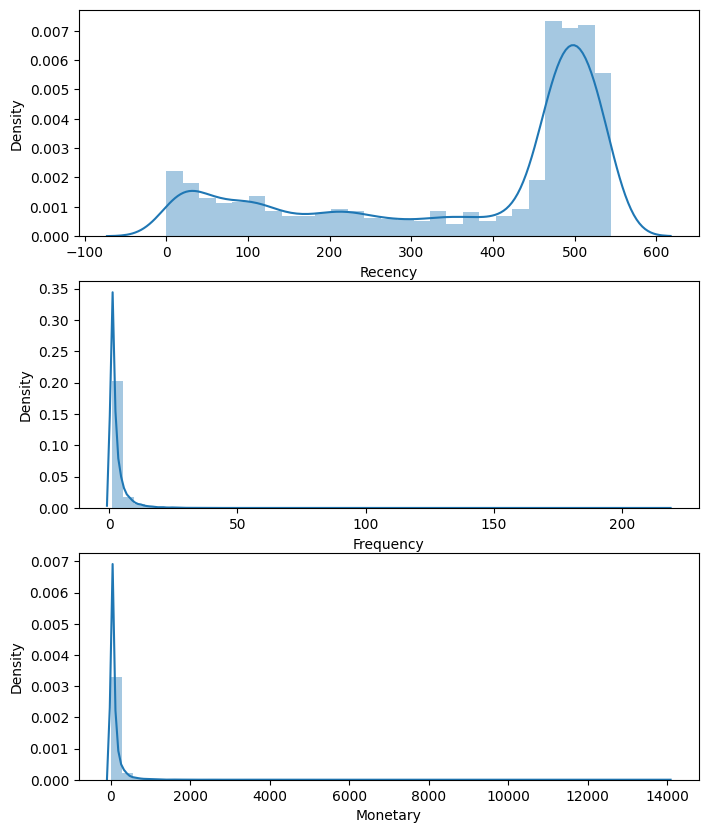

In [15]:
### Virsulization
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sns.distplot(df_RFM['Recency'])# Plot distribution of R
plt.subplot(3, 1, 2)
sns.distplot(df_RFM['Frequency'])# Plot distribution of F
plt.subplot(3, 1, 3)
sns.distplot(df_RFM['Monetary']) # Plot distribution of M
plt.show()

In [16]:
# Create labels for Recency, Frequency, Monetary
r_labels = range(4, 0, -1) # số ngày tính từ lần cuối mua hàng lớn thì gán nhãn nhỏ, ngược lại thì nhãn lớn
f_labels = range(1, 5)
m_labels = range(1, 5)

In [17]:
[*r_labels]

[4, 3, 2, 1]

In [18]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)
f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)
m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [19]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
07592,1,201,13990.93,4,4,4
14048,0,217,8976.33,4,4,4
07983,5,149,6973.07,4,4,4
19339,445,56,6552.70,3,4,4
07931,17,62,6497.18,4,4,4


### Concat RFM quartile values to create RFM Segments

In [20]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)

In [21]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
customer_id,,,,,,,
07592,1,201,13990.93,4,4,4,444
14048,0,217,8976.33,4,4,4,444
07983,5,149,6973.07,4,4,4,444
19339,445,56,6552.70,3,4,4,344
07931,17,62,6497.18,4,4,4,444


#### Count num of unique segments

In [22]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()

In [23]:
print(rfm_count_unique.sum())

44


#### Calculate RFM score and level

In [24]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,
07592,1,201,13990.93,4,4,4,444,12
14048,0,217,8976.33,4,4,4,444,12
07983,5,149,6973.07,4,4,4,444,12
19339,445,56,6552.70,3,4,4,344,11
07931,17,62,6497.18,4,4,4,444,12


In [25]:
def rfm_level(df):
    if (df['RFM_Score'] == 12):
        return 'gold customer'
    elif (df['R'] == 4 and df['F'] ==1 and df['M'] == 1):
        return 'new customer'
    else:
        if df['M'] == 4:
            return 'spender'

        elif df['F'] == 4:
            return 'loyal customer'

        elif df['R'] == 4:
            return 'recent customer'

        elif df['R'] == 1:
            return 'lost customer'

        elif df['M'] == 1:
            return 'thrifty'

        return 'regulars'

In [26]:
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)

In [27]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_id,,,,,,,,,
07592,1,201,13990.93,4,4,4,444,12,gold customer
14048,0,217,8976.33,4,4,4,444,12,gold customer
07983,5,149,6973.07,4,4,4,444,12,gold customer
19339,445,56,6552.70,3,4,4,344,11,spender
07931,17,62,6497.18,4,4,4,444,12,gold customer


In [28]:
df_RFM[::2000]

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_id,,,,,,,,,
07592,1,201,13990.93,4,4,4,444,12,gold customer
09681,20,7,274.13,4,4,4,444,12,gold customer
14232,25,3,156.50,4,3,4,434,11,spender
22510,463,1,104.13,3,1,3,313,7,regulars
18291,28,3,74.31,4,3,3,433,10,recent customer
21733,454,2,55.86,3,3,3,333,9,regulars
15207,337,2,42.46,3,3,2,332,8,regulars
12364,480,2,31.98,2,3,2,232,7,regulars
05637,523,1,26.16,1,1,2,112,4,lost customer


#### Number of segments

In [29]:
df_RFM['RFM_Level'].value_counts()

regulars           6017
lost customer      5674
gold customer      3407
thrifty            3246
spender            2486
loyal customer     1560
recent customer    1180
Name: RFM_Level, dtype: int64

#### Calculate mean values for each segment

In [30]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [31]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,gold customer,70.0,10.0,387.0,3407,14.45
1,lost customer,524.0,1.0,29.0,5674,24.07
2,loyal customer,202.0,4.0,67.0,1560,6.62
3,recent customer,107.0,2.0,59.0,1180,5.01
4,regulars,439.0,2.0,47.0,6017,25.53
5,spender,323.0,4.0,208.0,2486,10.55
6,thrifty,481.0,1.0,13.0,3246,13.77


#### TreeMap

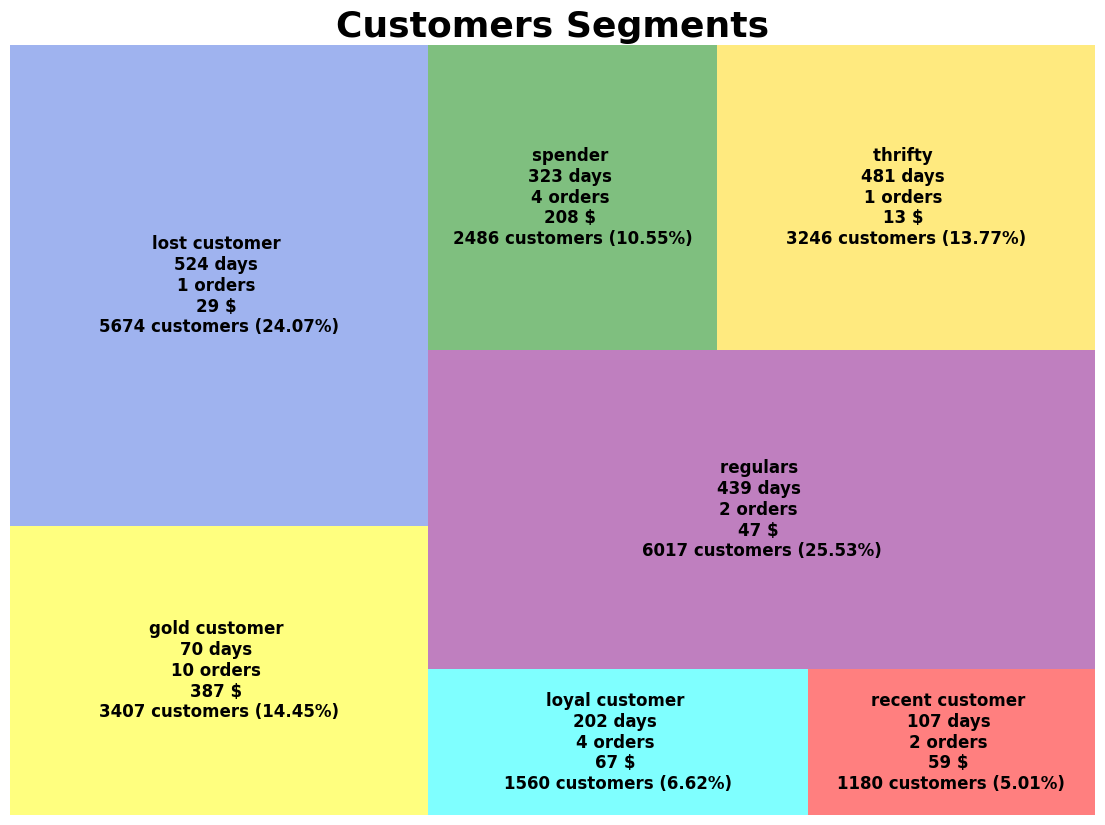

In [32]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'recent_customer':'yellow','spender':'royalblue', 'thrifty':'cyan',
               'lost customer':'red', 'loyal customer':'purple', 'new customer':'green', 'gold customer':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [33]:
import plotly.express as px
fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()

đánh giá kết quả:

lost customer: khách hàng tạo ra ít giá trị, ko thường xuyên, đã lâu ko mua hàng, trung bình chỉ 1 order và ko quay lại nửa, nhóm này nên có chương trình giới thiệu sản phẩm cd mới vì có thể luồng cd trước đây ko phù hợp thị hiếu nên họ ko quay lại mua hàng

spender: nhóm khách hàng chi nhiều tiền, nhóm này nên đưa ra chương trình voucher tích điểm cho họ

thrifty: nhóm khách hàng chi ít tiền cho mỗi lần mua hàng, nhóm này nên đưa ra chương trình discount trên đơn hàng lớn để kích thích họ mua thêm

regulars: nhóm khách hàng trung bình, nhóm này nên đề ra chương trình reminder marketing để họ ko bị quên thương hiệu khi có nhu cầu mua cd

gold_customer: nhóm mua nhiều tiền, mua thường xuyên, mua trong thời gian gần đây, nhóm này nên có chương trình tri ân khách hàng thân thiết cho nhóm này

loyal_customer: nhóm khách hàng trung thành, thân quen. Nhóm này nên có chương trình membership

recent_customer: khách hàng tiềm năng mua hàng trong thời gian gần đây, nhóm này nên có ưu đãi đặc biệt khi mua hàng để thu hút khách hàng mới

## Kmeans clusters with the Elbow Method

In [34]:
df_now = df_RFM[['Recency','Frequency','Monetary']]
df_now

,Recency,Frequency,Monetary
customer_id,,,
07592,1,201,13990.93
14048,0,217,8976.33
07983,5,149,6973.07
19339,445,56,6552.70
07931,17,62,6497.18
...,...,...,...
22848,465,1,0.00
15258,491,1,0.00
01381,540,1,0.00


In [35]:
from sklearn.preprocessing import MinMaxScaler
mmScaler = MinMaxScaler()
mmScaler.fit(df_now)
data_sub = mmScaler.transform(df_now)

In [36]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_sub)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

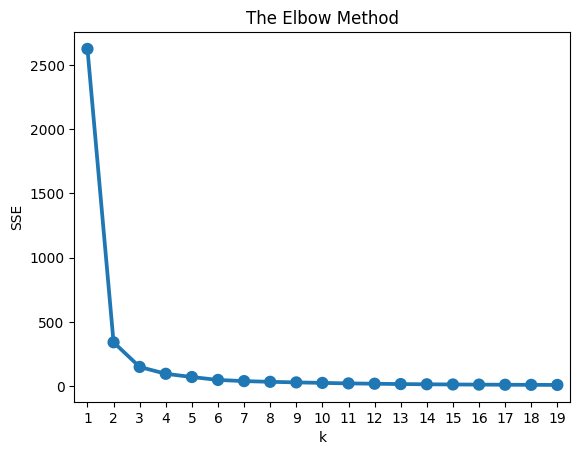

In [37]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [38]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(data_sub)
model.labels_.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(23570,)

In [39]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

<ipython-input-39-4b7bf47954b9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        497.73      1.23    38.97  14259
1        202.91      4.18   151.01   2632
2        354.19      3.21   113.65   2171
3         56.63      7.58   288.46   4508

In [40]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df_now.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)
rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)
# Reset the index
rfm_agg2 = rfm_agg2.reset_index()
# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')
# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,498.0,1.0,39.0,14259,60.50
1,Cluster 1,203.0,4.0,151.0,2632,11.17
2,Cluster 2,354.0,3.0,114.0,2171,9.21
3,Cluster 3,57.0,8.0,288.0,4508,19.13


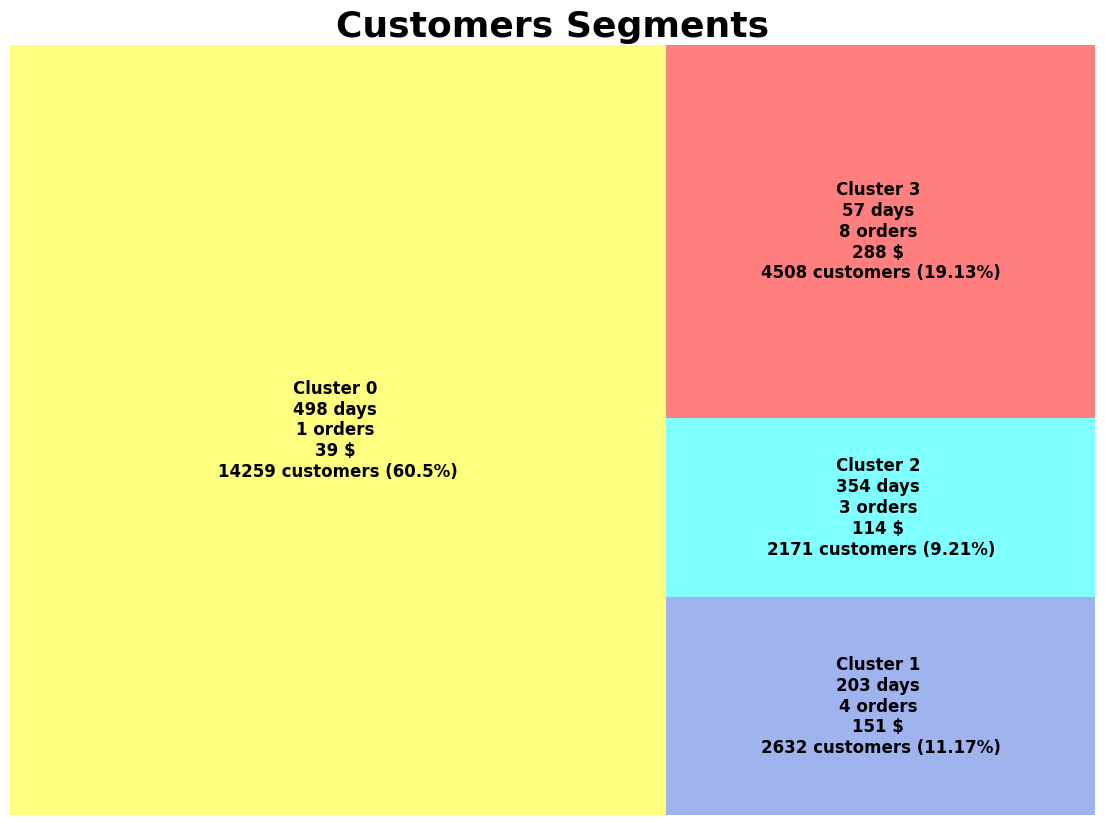

In [41]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)
colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}
squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )
plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.savefig('Unsupervised Segments.png')
plt.show()

In [42]:
import plotly.express as px
fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

### Hierarchical Clustering

In [43]:
df_now = df_now[['Recency','Frequency','Monetary']]

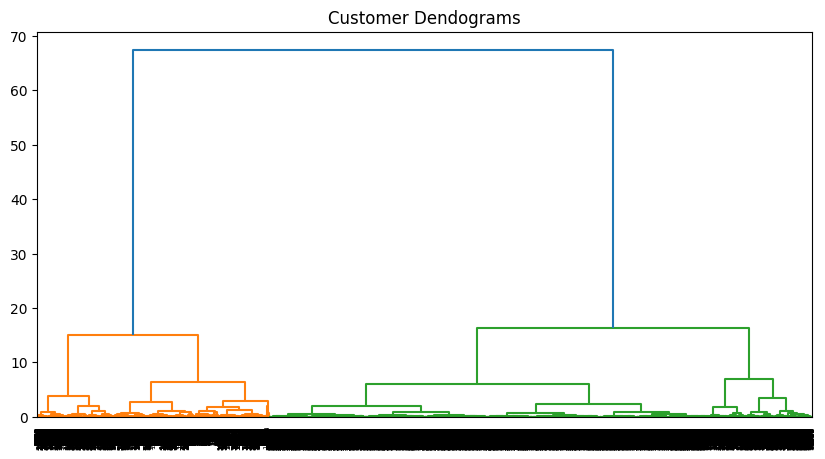

In [44]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 5))
plt.title("Customer Dendograms")
dend = hierarchy.dendrogram(hierarchy.linkage(data_sub, method='ward'))

In [45]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 4,
affinity='euclidean',
linkage='ward')
cluster.fit(data_sub)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [46]:
df_now["Cluster"] = cluster.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        376.52      3.07   109.27   3100
1         59.71      7.49   284.86   4693
2        501.05      1.14    35.37  13418
3        205.57      4.11   148.41   2359

In [47]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df_now.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,377.0,3.0,109.0,3100,13.15
1,Cluster 1,60.0,7.0,285.0,4693,19.91
2,Cluster 2,501.0,1.0,35.0,13418,56.93
3,Cluster 3,206.0,4.0,148.0,2359,10.01


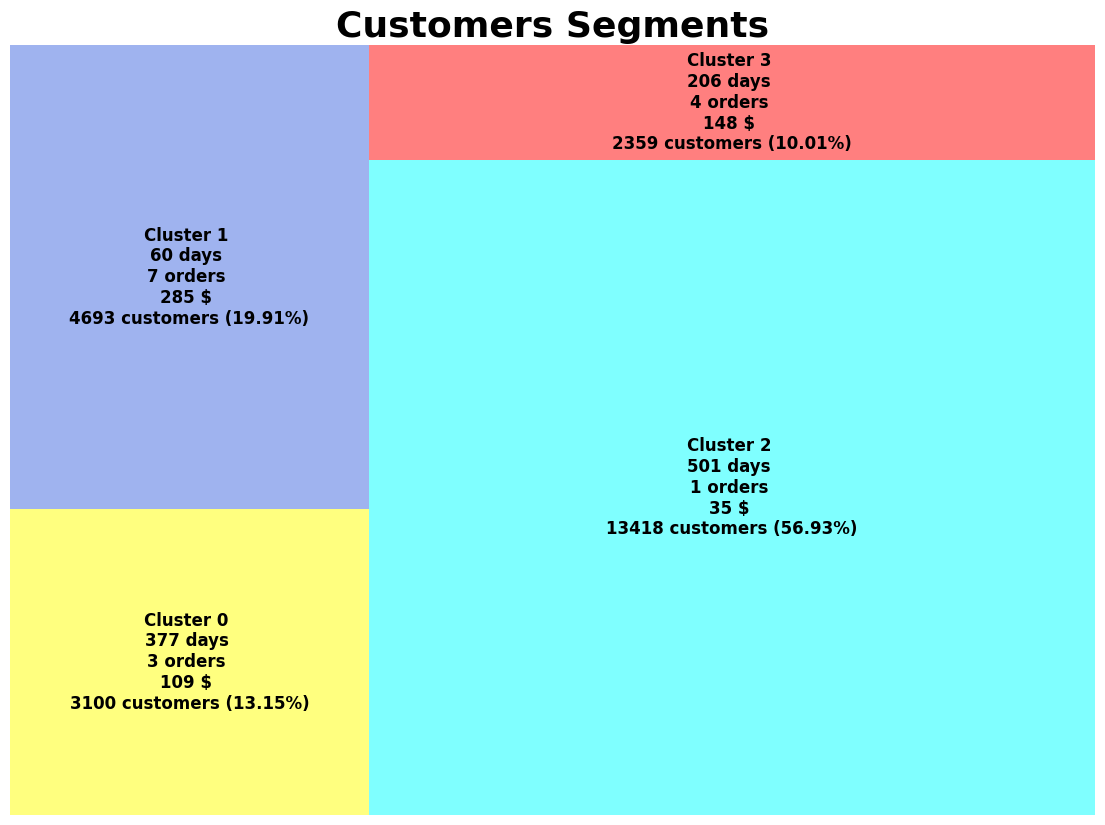

In [48]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)
colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}
squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )
plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.savefig('Unsupervised Segments.png')
plt.show()

In [49]:
import plotly.express as px
fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

### KNN spark

In [50]:
!pip install findspark
!pip install pyspark
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=5271b2b594f7c45cad9ad4f16a33f4628e6040cb9a7659fc3b33c1693c3eceae
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [51]:
import pyspark

In [52]:
from pyspark.sql import SparkSession

In [53]:
spark = SparkSession.builder.appName('kmeans_cd').getOrCreate()

In [54]:
df_now = df_now[['Recency','Frequency','Monetary']]

In [55]:
data = spark.createDataFrame(df_now)

In [56]:
data.show(3)

+-------+---------+--------+
|Recency|Frequency|Monetary|
+-------+---------+--------+
|      1|      201|13990.93|
|      0|      217| 8976.33|
|      5|      149| 6973.07|
+-------+---------+--------+
only showing top 3 rows



In [57]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [58]:
vec_assembler = VectorAssembler(inputCols = data.columns,
 outputCol='features')

In [59]:
final_data = vec_assembler.transform(data)

In [60]:
from pyspark.ml.feature import MinMaxScaler

In [61]:
scaler = MinMaxScaler(inputCol="features",
 outputCol="scaledFeatures")

In [62]:
scalerModel = scaler.fit(final_data)

In [63]:
sub_data = scalerModel.transform(final_data)

In [64]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [65]:
k_list = []
silhouette_list = []
sil_str = ""
for k in range(2,11):
    kmeans = KMeans(featuresCol="scaledFeatures", k= k)
    model = kmeans.fit(sub_data)
    k_list.append(k)

    #silhoutte
    predictions = model.transform(sub_data)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

    sil_str = "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"
    print(sil_str)

With k =2- Silhouette = 0.6349091462927954

With k =3- Silhouette = 0.48507001996075394

With k =4- Silhouette = 0.3968324536956053

With k =5- Silhouette = 0.4363596511676744

With k =6- Silhouette = 0.00010575989404381474

With k =7- Silhouette = -0.018612132142568922

With k =8- Silhouette = -0.0873810798410212

With k =9- Silhouette = -0.11462221035813303

With k =10- Silhouette = -0.14103447550227843



In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

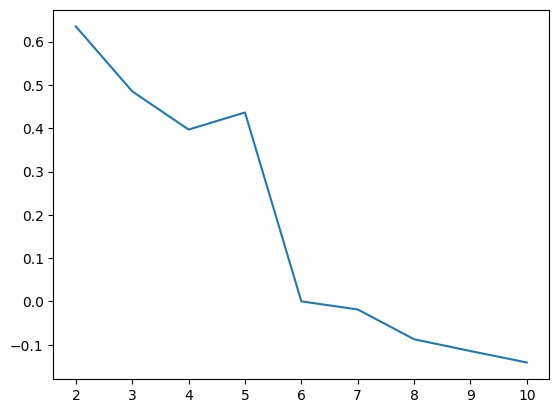

In [67]:
plt.plot(k_list, silhouette_list)
plt.show()

In [68]:
kmeans = KMeans(featuresCol='scaledFeatures',k=2)
model = kmeans.fit(sub_data)

In [69]:
predictions = model.transform(sub_data)

In [70]:
predictions.select("prediction").show(5)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         0|
|         1|
+----------+
only showing top 5 rows



In [71]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 7422|
|         0|16148|
+----------+-----+



In [72]:
data_result = predictions.select("prediction")
data_result.columns

['prediction']

In [73]:
temp = sub_data.select("features").rdd.map(lambda x: \
 x[0].toArray().tolist()).toDF()

In [74]:
import pyspark.sql.functions as f

In [75]:
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
data_result=data_result.withColumn('row_index',
 f.monotonically_increasing_id())
temp = temp.join(data_result,
 on=["row_index"]).sort("row_index").drop("row_index")

In [76]:
temp.show(3)

+---+-----+--------+----------+
| _1|   _2|      _3|prediction|
+---+-----+--------+----------+
|1.0|201.0|13990.93|         1|
|0.0|217.0| 8976.33|         1|
|5.0|149.0| 6973.07|         1|
+---+-----+--------+----------+
only showing top 3 rows



In [77]:
from pyspark.sql.functions import col
temp = temp.select(col("_1").alias("x_scale"),col("_2").alias("y_scale"),col("_3").alias("z_scale"),"prediction")

In [78]:
df = temp.toPandas()

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

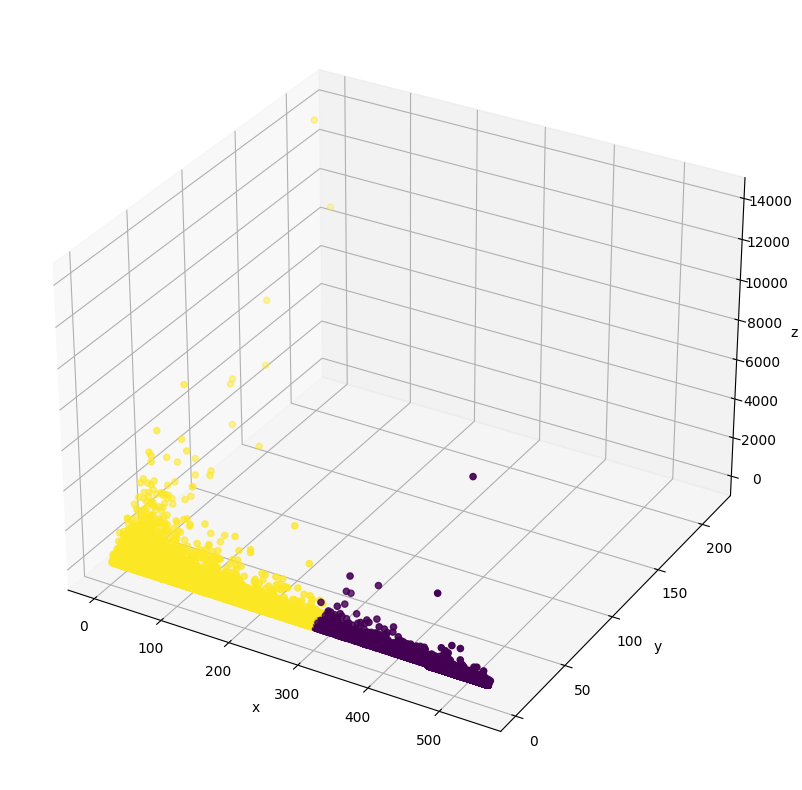

In [80]:
threedee = plt.figure(figsize=(12,10))
ax = threedee.add_subplot(projection='3d')
ax.scatter(df.x_scale, df.y_scale,
 df.z_scale,
 c=df.prediction)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [81]:
df.head()

,x_scale,y_scale,z_scale,prediction
0,1.0,201.0,13990.93,1
1,0.0,217.0,8976.33,1
2,5.0,149.0,6973.07,1
3,445.0,56.0,6552.70,0
4,17.0,62.0,6497.18,1


In [82]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df.groupby('prediction').agg({
    'x_scale': 'mean',
    'y_scale': 'mean',
    'z_scale': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['prediction'] = 'Cluster '+ rfm_agg2['prediction'].astype('str')

# Print the aggregated dataset
rfm_agg2

,prediction,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,482.0,1.0,47.0,16148,68.51
1,Cluster 1,117.0,6.0,234.0,7422,31.49


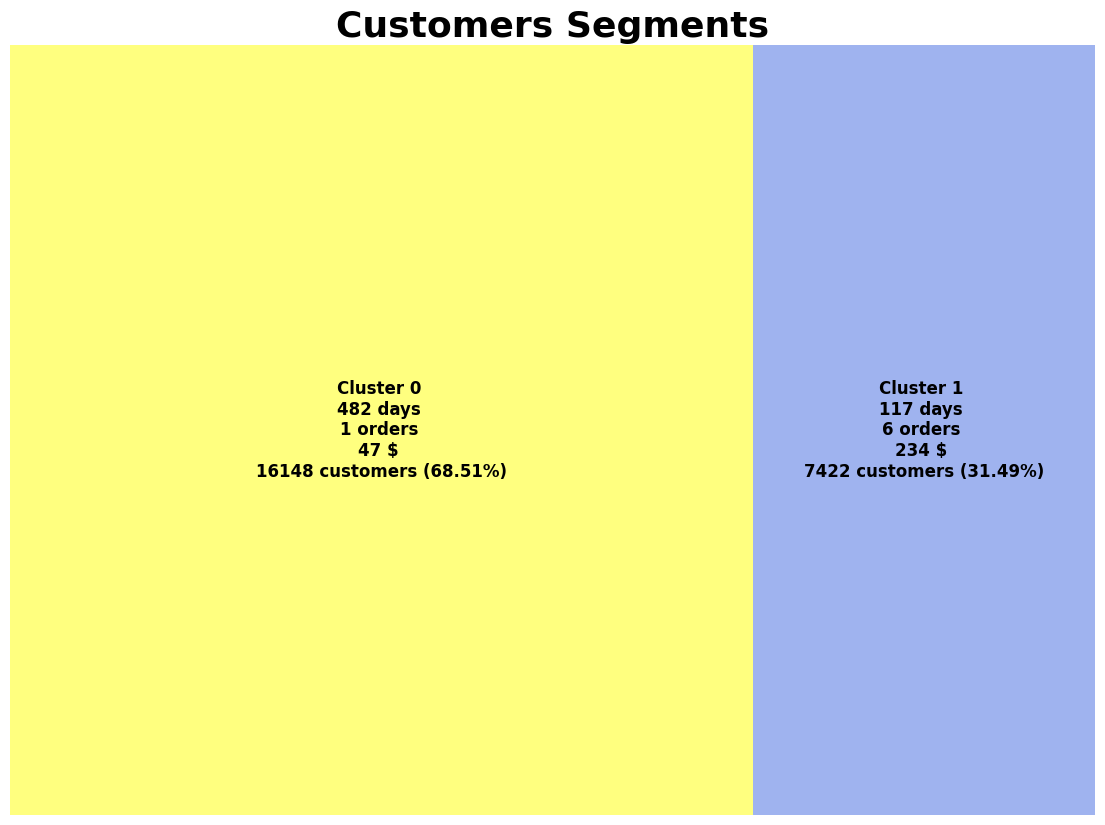

In [83]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Unsupervised Segments.png')
plt.show()

In [84]:
import plotly.express as px
fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="prediction",
           hover_name="prediction", size_max=100)
fig.show()

Nhận xet Kmean và hierarchical clustering:

Kmean và hierarchical clustering với k bằng 4 phân loại tương đối giống nhau, đều chia làm 4 phân khúc.

phân khúc VIP: đã mua nhiều lần, tổng giá trị tạo ra lớn và là khách hàng thường trực có mua hàng gần đây

Phân khúc Gold: mức độ thấp hơn VIP

Phân khúc Silver: mức độ thấp hơn Gold

Phân khúc regulars: khách hàng thường, 3 chỉ số thấp nhất

Riêng thuật toán spark kmean chỉ phân làm 2 nhóm là khách hàng thân thiết và khách hàng thường